In [317]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
!pip install pyramid
from pmdarima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [318]:
covid=pd.read_csv("/content/TAMILNADU (1).csv")
covid.head()

,date,state,confirmed,new conf,recovered,new rec,dead,new dead,other,tested
0,04-01-2021,Tamil Nadu,889490,2817,859709,1634,12738,19,0,19681244
1,04-02-2021,Tamil Nadu,892780,3290,861424,1715,12750,12,0,19767310
2,04-03-2021,Tamil Nadu,896226,3446,863258,1834,12764,14,0,19849388
3,04-04-2021,Tamil Nadu,899807,3581,865071,1813,12778,14,0,19932179
4,04-05-2021,Tamil Nadu,903479,3672,866913,1842,12789,11,0,20012235


In [319]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (183, 10)
Checking for null values:
 date         0
state        0
confirmed    0
new conf     0
recovered    0
new rec      0
dead         0
new dead     0
other        0
tested       0
dtype: int64
Checking Data-type of each column:
 date         object
state        object
confirmed     int64
new conf      int64
recovered     int64
new rec       int64
dead          int64
new dead      int64
other         int64
tested        int64
dtype: object


In [320]:
covid["date"]=pd.to_datetime(covid["date"])
covid

,date,state,confirmed,new conf,recovered,new rec,dead,new dead,other,tested
0,2021-04-01,Tamil Nadu,889490,2817,859709,1634,12738,19,0,19681244
1,2021-04-02,Tamil Nadu,892780,3290,861424,1715,12750,12,0,19767310
2,2021-04-03,Tamil Nadu,896226,3446,863258,1834,12764,14,0,19849388
3,2021-04-04,Tamil Nadu,899807,3581,865071,1813,12778,14,0,19932179
4,2021-04-05,Tamil Nadu,903479,3672,866913,1842,12789,11,0,20012235
...,...,...,...,...,...,...,...,...,...,...
178,2021-09-26,Tamil Nadu,2657266,1694,2604491,1658,35490,14,0,46386232
179,2021-09-27,Tamil Nadu,2658923,1657,2606153,1662,35509,19,0,46538112
180,2021-09-28,Tamil Nadu,2660553,1630,2607796,1643,35526,17,0,46688837
181,2021-09-29,Tamil Nadu,2662177,1624,2609435,1639,35550,24,0,46840515


In [321]:
grouped=covid.groupby(["state","date"]).agg({"confirmed":'sum',"new conf":'sum',"recovered":'sum',"new rec":'sum',"dead":'sum',"new dead":'sum'})
grouped

confirmed  new conf  recovered  new rec   dead  new dead
state      date                                                                
Tamil Nadu 2021-04-01     889490      2817     859709     1634  12738        19
           2021-04-02     892780      3290     861424     1715  12750        12
           2021-04-03     896226      3446     863258     1834  12764        14
           2021-04-04     899807      3581     865071     1813  12778        14
           2021-04-05     903479      3672     866913     1842  12789        11
...                          ...       ...        ...      ...    ...       ...
           2021-09-26    2657266      1694    2604491     1658  35490        14
           2021-09-27    2658923      1657    2606153     1662  35509        19
           2021-09-28    2660553      1630    2607796     1643  35526        17
           2021-09-29    2662177      1624    2609435     1639  35550        24
           2021-09-30    2663789      1612    2611061     1626  35578        28

[183 rows x 6 columns]

In [322]:
grouped["Active Cases"]=grouped["confirmed"]-grouped["recovered"]-grouped["dead"]
grouped["log_confirmed"]=np.log(grouped["confirmed"])
grouped["log_active"]=np.log(grouped["Active Cases"])
grouped

confirmed  new conf  ...  log_confirmed  log_active
state      date                             ...                           
Tamil Nadu 2021-04-01     889490      2817  ...      13.698404    9.743495
           2021-04-02     892780      3290  ...      13.702095    9.831239
           2021-04-03     896226      3446  ...      13.705948    9.913636
           2021-04-04     899807      3581  ...      13.709936    9.996887
           2021-04-05     903479      3672  ...      13.714008   10.076474
...                          ...       ...  ...            ...         ...
           2021-09-26    2657266      1694  ...      14.792808    9.757594
           2021-09-27    2658923      1657  ...      14.793432    9.756205
           2021-09-28    2660553      1630  ...      14.794045    9.754465
           2021-09-29    2662177      1624  ...      14.794655    9.752199
           2021-09-30    2663789      1612  ...      14.795260    9.749753

[183 rows x 9 columns]

In [323]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["date"]).agg({"confirmed":'sum',"recovered":'sum',"new conf":'sum','new rec':'sum','new dead':'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()
datewise

,confirmed,recovered,new conf,new rec,new dead,Days Since
date,,,,,,
2021-04-01,889490,859709,2817,1634,19,0 days
2021-04-02,892780,861424,3290,1715,12,1 days
2021-04-03,896226,863258,3446,1834,14,2 days
2021-04-04,899807,865071,3581,1813,14,3 days
2021-04-05,903479,866913,3672,1842,11,4 days
...,...,...,...,...,...,...
2021-09-26,2657266,2604491,1694,1658,14,178 days
2021-09-27,2658923,2606153,1657,1662,19,179 days
2021-09-28,2660553,2607796,1630,1643,17,180 days


In [324]:
fig=px.bar(x=datewise.index,y=datewise["new conf"])
fig.update_layout(title="Distribution of Number of new confirmed Cases",
                  xaxis_title="Date",yaxis_title="Number of deaths",)
fig.show()

In [325]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["new conf"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["new rec"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["new dead"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in Tamil Nadu",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

GROWTH RATE OF TAMIL NADU


In [326]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new conf"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new rec"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new dead"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

GROWTH FACTOR


In [327]:
#linear regression


In [328]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [329]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [330]:
lin_reg=LinearRegression(normalize=True)

In [331]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["new conf"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [332]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [333]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["new conf"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["new conf"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  3196.6196247443013


In [334]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new conf"],
                    mode='lines+markers',name="Train Data for newly confirmed cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="newly dead Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="newly confirmed cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [335]:
#polynomial regression 
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
poly = PolynomialFeatures(degree = 8) 

In [336]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["new conf"]

In [337]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [338]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["new conf"],prediction_poly))
model_scores=[]
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  26590.061911654382


In [339]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new conf"],
                    mode='lines+markers',name="Train Data for newly confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="new dead Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="newly confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


<Figure size 792x432 with 0 Axes>

SVM PREDICTION

In [340]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [341]:
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [342]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["new conf"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [343]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [344]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["new conf"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["new conf"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  6568.837247394424


In [345]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["new conf"],
                    mode='lines+markers',name="Train Data for newly confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="newly dead Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [346]:
#new polynomial
new_prediction_poly=[]
for i in range(1,365):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [347]:
#new svm prediction
new_date=[]
new_prediction_svm=[]
for i in range(1,365):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [348]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_poly,new_prediction_svm),
                               columns=["date","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction
0,2021-10-01,-57857.414316,-7110.881976
1,2021-10-02,-69159.924645,-7579.369025
2,2021-10-03,-82011.026403,-8060.761151
3,2021-10-04,-96565.083352,-8555.341192
4,2021-10-05,-112987.621811,-9063.396606
...,...,...,...
359,2022-09-25,-181239065799.774628,-9506749.170574
360,2022-09-26,-184506437182.473389,-9612554.231288
361,2022-09-27,-187825081870.263672,-9719338.054409
362,2022-09-28,-191195685942.398560,-9827107.869965


FORECASTING

HOLT'S LINEAR MODEL

In [349]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [350]:
holt=Holt(np.asarray(model_train["new conf"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)     

In [351]:
y_pred["Holt"]=holt.forecast(10)
model_scores.append(np.sqrt(mean_squared_error(y_pred["new conf"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["new conf"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  72.41490680468647


In [352]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new conf"],
                    mode='lines+markers',name="Train Data for newly confirmed cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new conf"],
                    mode='lines+markers',name="Validation Data for newly confirmed cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of newly confirmed Cases",))
fig.update_layout(title="newly dead Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [353]:
#holt new prediction
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,365):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2021-10-01,-57857.414316,-7110.881976,1752.128571
1,2021-10-02,-69159.924645,-7579.369025,1758.252288
2,2021-10-03,-82011.026403,-8060.761151,1764.376006
3,2021-10-04,-96565.083352,-8555.341192,1770.499724
4,2021-10-05,-112987.621811,-9063.396606,1776.623441
...,...,...,...,...
359,2022-09-25,-181239065799.774628,-9506749.170574,3950.543213
360,2022-09-26,-184506437182.473389,-9612554.231288,3956.666931
361,2022-09-27,-187825081870.263672,-9719338.054409,3962.790649
362,2022-09-28,-191195685942.398560,-9827107.869965,3968.914366


HOLT'S WINTER MODEL

In [354]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [355]:
es=ExponentialSmoothing(np.asarray(model_train['new conf']),seasonal_periods=14,trend='add', seasonal='mul').fit()

In [356]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["new conf"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["new conf"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  50.406713404596836


In [357]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new conf"],
                    mode='lines+markers',name="Train Data for new confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new conf"],
                    mode='lines+markers',name="Validation Data for newly confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of newly confirmed Cases",))
fig.update_layout(title="newly dead Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="new dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [358]:
#holt winter new prediction
holt_winter_new_prediction=[]
for i in range(1,365):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2021-10-01,-57857.414316,-7110.881976,1752.128571,1640.798855
1,2021-10-02,-69159.924645,-7579.369025,1758.252288,1607.742318
2,2021-10-03,-82011.026403,-8060.761151,1764.376006,1605.678205
3,2021-10-04,-96565.083352,-8555.341192,1770.499724,1564.878462
4,2021-10-05,-112987.621811,-9063.396606,1776.623441,1558.652047


In [359]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

AR MODEL (AUTO ARIMA)

In [360]:
model_ar= auto_arima(model_train["new conf"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["new conf"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2586.802, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2569.663, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2559.404, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2549.796, Time=0.14 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=2548.703, Time=0.09 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 0.330 seconds


ARIMA(maxiter=50, method='lbfgs', order=(4, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [361]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [362]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["new conf"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["new conf"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  92.94278281157732


In [363]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new conf"],
                    mode='lines+markers',name="Train Data for newly confirmed cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new conf"],
                    mode='lines+markers',name="Validation Data for newly confirmed cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of newly confirmed cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="newly dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [364]:
#ar model new prediction
AR_model_new_prediction=[]
for i in range(1,365):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2021-10-01,-57857.414316,-7110.881976,1752.128571,1640.798855,1508.598191
1,2021-10-02,-69159.924645,-7579.369025,1758.252288,1607.742318,1491.754239
2,2021-10-03,-82011.026403,-8060.761151,1764.376006,1605.678205,1474.475899
3,2021-10-04,-96565.083352,-8555.341192,1770.499724,1564.878462,1456.536908
4,2021-10-05,-112987.621811,-9063.396606,1776.623441,1558.652047,1437.958319


MA MODEL (AUTO ARIMA)

In [365]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [366]:
model_ma= auto_arima(model_train["new conf"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["new conf"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2586.802, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2545.289, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2543.313, Time=0.24 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0] intercept
Total fit time: 0.379 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [367]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [368]:
model_scores.append(np.sqrt(mean_squared_error(valid["new conf"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["new conf"],prediction_ma)))

Root Mean Square Error for MA Model:  127.294068554433


In [369]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new conf"],
                    mode='lines+markers',name="Train Data for newly confirmed cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new conf"],
                    mode='lines+markers',name="Validation Data for newly confirmed cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for newly confirmed cases",))
fig.update_layout(title="newly dead Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="newly dead Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [370]:
#ma model new prediction
MA_model_new_prediction=[]
for i in range(1,365):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head(60)

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2021-10-01,-57857.414316,-7110.881976,1752.128571,1640.798855,1508.598191,1410.135755
1,2021-10-02,-69159.924645,-7579.369025,1758.252288,1607.742318,1491.754239,1374.434318
2,2021-10-03,-82011.026403,-8060.761151,1764.376006,1605.678205,1474.475899,1336.472958
3,2021-10-04,-96565.083352,-8555.341192,1770.499724,1564.878462,1456.536908,1296.251675
4,2021-10-05,-112987.621811,-9063.396606,1776.623441,1558.652047,1437.958319,1253.770470
5,2021-10-06,-131455.904362,-9585.219529,1782.747159,1590.729115,1418.854541,1209.029343
6,2021-10-07,-152159.523545,-10121.106818,1788.870877,1606.821199,1399.254689,1162.028292
7,2021-10-08,-175301.015941,-10671.360109,1794.994594,1627.293933,1379.119199,1112.767319
8,2021-10-09,-201096.497090,-11236.285859,1801.118312,1629.731715,1358.416878,1061.246424
9,2021-10-10,-229776.317668,-11816.195406,1807.242030,1617.738185,1337.155842,1007.465606


ARIMA MODEL (AUTO ARIMA)

In [371]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [372]:
model_arima= auto_arima(model_train["new conf"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["new conf"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2586.802, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2545.289, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2543.313, Time=0.24 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=2544.982, Time=0.33 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2569.663, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2544.086, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=2545.333, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2540.423, Time=0.59 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2559.404, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2543.910, Time=0.47 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2538.633, Time=0.37 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=2527.790, Time=0.69 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2549.796, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2543.516, Time=0.25 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=2536.204, Time=0.79 sec

Best mode

ARIMA(maxiter=50, method='lbfgs', order=(2, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [373]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [374]:
model_scores.append(np.sqrt(mean_squared_error(valid["new conf"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["new conf"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  320.40460586032526


In [375]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new conf"],
                    mode='lines+markers',name="Train Data for newly confirmed cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new conf"],
                    mode='lines+markers',name="Validation Data for newly confirmed cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for newly confirmed cases",))
fig.update_layout(title="newly dead Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="newly confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [376]:
ARIMA_model_new_prediction=[]
for i in range(1,365):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2021-10-01,-57857.414316,-7110.881976,1752.128571,1640.798855,1508.598191,1410.135755,992.081416
1,2021-10-02,-69159.924645,-7579.369025,1758.252288,1607.742318,1491.754239,1374.434318,904.793687
2,2021-10-03,-82011.026403,-8060.761151,1764.376006,1605.678205,1474.475899,1336.472958,821.579598
3,2021-10-04,-96565.083352,-8555.341192,1770.499724,1564.878462,1456.536908,1296.251675,732.542447
4,2021-10-05,-112987.621811,-9063.396606,1776.623441,1558.652047,1437.958319,1253.770470,628.465858


SARIMA MODEL (AUTO ARIMA)

In [377]:
model_sarima= auto_arima(model_train["new conf"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["new conf"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=2575.216, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=2584.809, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=2553.499, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2532.729, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=2543.331, Time=0.05 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2527.680, Time=0.36 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=2528.559, Time=0.13 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=2529.507, Time=0.48 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=2529.602, Time=1.00 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=2528.369, Time=0.51 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=2527.507, Time=0.29 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=2575.778, Time=0.06 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=2527.726, Time=0.49 sec
 ARIMA(0,2,2)(2,0,0)[7]             : AIC=2527.485, Time=0.35 sec
 ARIMA(0,2,2)(1,0,0)[7]          

ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 0, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [378]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [379]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["new conf"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["new conf"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  49.77781821335632


In [380]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new conf"],
                    mode='lines+markers',name="Train Data for newly confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new conf"],
                    mode='lines+markers',name="Validation Data for newly confirned Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for newly confirmed cases",))
fig.update_layout(title="newly dead Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="new confirmedd cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [381]:
SARIMA_model_new_prediction=[]
for i in range(1,365):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2021-10-01,-57857.414316,-7110.881976,1752.128571,1640.798855,1508.598191,1410.135755,992.081416,1705.148925
1,2021-10-02,-69159.924645,-7579.369025,1758.252288,1607.742318,1491.754239,1374.434318,904.793687,1702.995145
2,2021-10-03,-82011.026403,-8060.761151,1764.376006,1605.678205,1474.475899,1336.472958,821.579598,1711.200143
3,2021-10-04,-96565.083352,-8555.341192,1770.499724,1564.878462,1456.536908,1296.251675,732.542447,1703.981908
4,2021-10-05,-112987.621811,-9063.396606,1776.623441,1558.652047,1437.958319,1253.770470,628.465858,1704.488696
...,...,...,...,...,...,...,...,...,...
359,2022-09-25,-181239065799.774628,-9506749.170574,3950.543213,-887.170651,-39648.392531,-156631.567044,-386524.975147,2032.708842
360,2022-09-26,-184506437182.473389,-9612554.231288,3956.666931,-893.940353,-39861.344688,-157478.580699,-388598.738619,2033.598124
361,2022-09-27,-187825081870.263672,-9719338.054409,3962.790649,-900.782544,-40074.843001,-158327.854275,-390678.023579,2034.487406
362,2022-09-28,-191195685942.398560,-9827107.869965,3968.914366,-917.690715,-40288.887472,-159179.387775,-392762.830757,2035.376688


FB PROPHET

In [382]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_conf=pd.DataFrame(zip(list(datewise.index),list(datewise["new conf"])),columns=['ds','y'])

In [383]:
prophet_c.fit(prophet_conf)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [384]:
forecast_c=prophet_c.make_future_dataframe(periods=364)
forecast_conf=forecast_c.copy()

In [385]:
conf_forecast=prophet_c.predict(forecast_c)
print(conf_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

            ds          yhat    yhat_lower    yhat_upper
0   2021-04-01  17231.437998   1796.442001  31133.668752
1   2021-04-02  17207.034314   2862.777782  32450.727027
2   2021-04-03  17371.087344   2801.508073  33437.082242
3   2021-04-04  17484.688428   1751.709610  33448.712576
4   2021-04-05  17408.456269   2386.975083  32024.476549
..         ...           ...           ...           ...
542 2022-09-25 -56541.020690 -82888.289127 -28672.987143
543 2022-09-26 -56757.637570 -84134.977038 -27532.484985
544 2022-09-27 -56985.599293 -84104.200142 -28803.806905
545 2022-09-28 -56885.793229 -83613.391038 -26663.375240
546 2022-09-29 -57419.630196 -85160.751845 -28876.317179

[547 rows x 4 columns]


In [386]:
model_scores.append(np.sqrt(mean_squared_error(datewise["new conf"],conf_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["new conf"],conf_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  7954.959891233318


Figure(720x432)


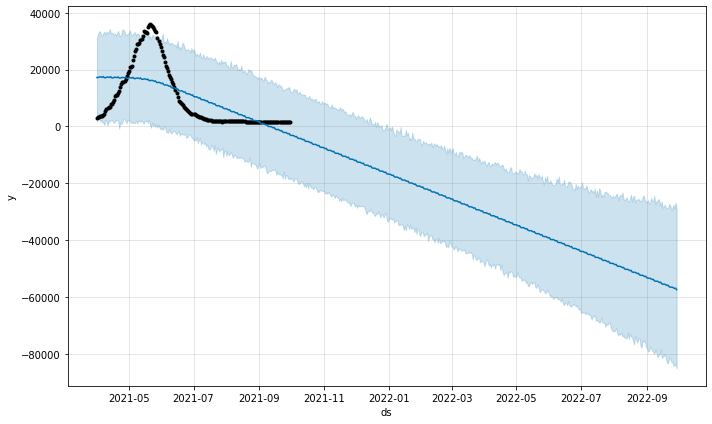

In [387]:
print(prophet_c.plot(conf_forecast))

Figure(648x432)


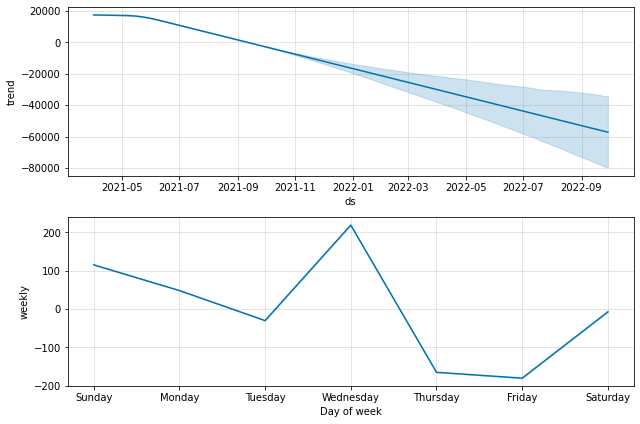

In [388]:
print(prophet_c.plot_components(conf_forecast))

In [389]:
model_names=["Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
7,SARIMA Model,49.777818
3,Holt's Winter Model,50.406713
2,Holt's Linear,72.414907
4,Auto Regressive Model (AR),92.942783
5,Moving Average Model (MA),127.294069
6,ARIMA Model,320.404606
1,Support Vector Machine Regressor,6568.837247
8,Facebook's Prophet Model,7954.959891
0,Polynomial Regression,26590.061912


In [390]:
model_predictions["Prophet's Prediction"]=list(conf_forecast["yhat"].tail(364))
model_predictions["Prophet's Upper Bound"]=list(conf_forecast["yhat_upper"].tail(364))
model_predictions["Prophet's Lower Bound"]=list(conf_forecast["yhat_lower"].tail(364))
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound,Prophet's Lower Bound
0,2021-10-01,-57857.414316,-7110.881976,1752.128571,1640.798855,1508.598191,1410.135755,992.081416,1705.148925,-3165.730171,12072.582072,-18185.120351
1,2021-10-02,-69159.924645,-7579.369025,1758.252288,1607.742318,1491.754239,1374.434318,904.793687,1702.995145,-3142.061862,12116.343394,-18416.560173
2,2021-10-03,-82011.026403,-8060.761151,1764.376006,1605.678205,1474.475899,1336.472958,821.579598,1711.200143,-3168.845499,13068.911347,-19337.938260
3,2021-10-04,-96565.083352,-8555.341192,1770.499724,1564.878462,1456.536908,1296.251675,732.542447,1703.981908,-3385.462380,13243.606262,-18515.879365
4,2021-10-05,-112987.621811,-9063.396606,1776.623441,1558.652047,1437.958319,1253.770470,628.465858,1704.488696,-3613.424102,12205.807856,-18201.209457
...,...,...,...,...,...,...,...,...,...,...,...,...
359,2022-09-25,-181239065799.774628,-9506749.170574,3950.543213,-887.170651,-39648.392531,-156631.567044,-386524.975147,2032.708842,-56541.020690,-28672.987143,-82888.289127
360,2022-09-26,-184506437182.473389,-9612554.231288,3956.666931,-893.940353,-39861.344688,-157478.580699,-388598.738619,2033.598124,-56757.637570,-27532.484985,-84134.977038
361,2022-09-27,-187825081870.263672,-9719338.054409,3962.790649,-900.782544,-40074.843001,-158327.854275,-390678.023579,2034.487406,-56985.599293,-28803.806905,-84104.200142
362,2022-09-28,-191195685942.398560,-9827107.869965,3968.914366,-917.690715,-40288.887472,-159179.387775,-392762.830757,2035.376688,-56885.793229,-26663.375240,-83613.391038


In [391]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new conf"],
                    mode='lines+markers',name="New confirmed Cases"))
fig.update_layout(title="confirmed Cases",
                 xaxis_title="Date",yaxis_title="Number of confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [392]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [393]:
model_arima_deaths=auto_arima(model_train["new conf"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["new conf"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2586.802, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2545.289, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2543.313, Time=0.25 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=2544.982, Time=0.36 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=2539.128, Time=0.40 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=2540.963, Time=0.67 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2569.663, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2544.086, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=2545.333, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2540.423, Time=0.60 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=2540.983, Time=0.41 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2559.404, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2543.910, Time=0.45 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2538.633, Time=0.36 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=2527.790, Time=0.68 sec
 ARIMA(3,2

ARIMA(maxiter=50, method='lbfgs', order=(2, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [394]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA conf Prediction"]=predictions_deaths

In [395]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["new dead"],predictions_deaths)))

Root Mean Square Error:  1376.6648833230674


In [396]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["new conf"],
                    mode='lines+markers',name="Train Data for confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["new conf"],
                    mode='lines+markers',name="Validation Data for confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA conf Prediction"],
                    mode='lines+markers',name="Prediction for confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [397]:
ARIMA_model_death_forecast=[]
for i in range(1,365):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [398]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2021-10-01,992.081416
1,2021-10-02,904.793687
2,2021-10-03,821.579598
3,2021-10-04,732.542447
4,2021-10-05,628.465858


In [399]:
model_predictions

,date,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound,Prophet's Lower Bound
0,2021-10-01,-57857.414316,-7110.881976,1752.128571,1640.798855,1508.598191,1410.135755,992.081416,1705.148925,-3165.730171,12072.582072,-18185.120351
1,2021-10-02,-69159.924645,-7579.369025,1758.252288,1607.742318,1491.754239,1374.434318,904.793687,1702.995145,-3142.061862,12116.343394,-18416.560173
2,2021-10-03,-82011.026403,-8060.761151,1764.376006,1605.678205,1474.475899,1336.472958,821.579598,1711.200143,-3168.845499,13068.911347,-19337.938260
3,2021-10-04,-96565.083352,-8555.341192,1770.499724,1564.878462,1456.536908,1296.251675,732.542447,1703.981908,-3385.462380,13243.606262,-18515.879365
4,2021-10-05,-112987.621811,-9063.396606,1776.623441,1558.652047,1437.958319,1253.770470,628.465858,1704.488696,-3613.424102,12205.807856,-18201.209457
...,...,...,...,...,...,...,...,...,...,...,...,...
359,2022-09-25,-181239065799.774628,-9506749.170574,3950.543213,-887.170651,-39648.392531,-156631.567044,-386524.975147,2032.708842,-56541.020690,-28672.987143,-82888.289127
360,2022-09-26,-184506437182.473389,-9612554.231288,3956.666931,-893.940353,-39861.344688,-157478.580699,-388598.738619,2033.598124,-56757.637570,-27532.484985,-84134.977038
361,2022-09-27,-187825081870.263672,-9719338.054409,3962.790649,-900.782544,-40074.843001,-158327.854275,-390678.023579,2034.487406,-56985.599293,-28803.806905,-84104.200142
362,2022-09-28,-191195685942.398560,-9827107.869965,3968.914366,-917.690715,-40288.887472,-159179.387775,-392762.830757,2035.376688,-56885.793229,-26663.375240,-83613.391038


In [400]:
model_predictions=model_predictions.groupby(["date"]).agg({"Holt's Linear Model Prediction":'sum',"Holt's Winter Model Prediction":'sum',"MA Model Prediction":'sum',"ARIMA Model Prediction":'sum',"SARIMA Model Prediction":'sum'})
model_predictions=model_predictions[0:60]
model_predictions.tail()

,Holt's Linear Model Prediction,Holt's Winter Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
date,,,,,
2021-11-25,2088.933042,1293.706992,-3909.428371,-12183.909301,1762.342334
2021-11-26,2095.056760,1249.865704,-4069.425551,-12581.894638,1763.219202
2021-11-27,2101.180478,1223.048426,-4231.682655,-12982.602725,1764.096889
2021-11-28,2107.304195,1219.829558,-4396.199681,-13385.692781,1765.013050
2021-11-29,2113.427913,1187.213494,-4562.976629,-13793.117058,1765.868226


In [401]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["Holt's Linear Model Prediction"],
                    mode='lines+markers',
                    name="Holt's Linear Model Prediction"))
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["MA Model Prediction"],
                    mode='lines+markers',
                    name='MA Model Prediction'))
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["ARIMA Model Prediction"],
                    mode='lines+markers',
                    name='ARIMA Model Prediction'))
fig.add_trace(go.Scatter(x=model_predictions.index, y=model_predictions["SARIMA Model Prediction"],
                    mode='lines+markers',
                    name='SARIMA Model Prediction'))
fig.update_layout(title="Rate of vaccinations administered",
                 xaxis_title="Date",yaxis_title="Number of deaths",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()